计算加权和，得到上下文向量

In [1]:
import numpy as np

T,H=5,4
hs=np.random.randn(T,H)
print(hs)
print(hs.shape)
a=np.array([0.8,0.1,0.03,0.05,0.02])

ar=a.reshape(5,1).repeat(4,axis=1)
print(ar)
print(ar.shape)

t=hs*ar
print(t)
print(t.shape)

c=np.sum(t,axis=0)
print(c)

[[-0.6362323  -0.16012426 -1.46528349  0.28276359]
 [ 0.47116399  0.90712425 -1.20825635  1.14211592]
 [-0.51413314 -0.90447643  0.61660069  0.86221684]
 [ 1.57686762 -0.30448975 -1.56493252 -1.07913931]
 [ 0.95625963  0.73467714 -0.68833283 -0.47960278]]
(5, 4)
[[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.03 0.03 0.03 0.03]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]]
(5, 4)
[[-0.50898584 -0.1280994  -1.17222679  0.22621087]
 [ 0.0471164   0.09071243 -0.12082564  0.11421159]
 [-0.01542399 -0.02713429  0.01849802  0.02586651]
 [ 0.07884338 -0.01522449 -0.07824663 -0.05395697]
 [ 0.01912519  0.01469354 -0.01376666 -0.00959206]]
(5, 4)
[-0.37932486 -0.06505222 -1.36656769  0.30273995]


批处理版的加权求和

In [2]:
N,T,H=10,5,4
hs=np.random.randn(N,T,H)
a=np.random.randn(N,T)
ar=a.reshape(N,T,1).repeat(H,axis=2)
print(ar)
print(ar.shape)

t=hs*ar
print(t)
print(t.shape)

c=np.sum(t,axis=1)
print(c)
print(c.shape)

[[[ 0.67973547  0.67973547  0.67973547  0.67973547]
  [ 1.65127805  1.65127805  1.65127805  1.65127805]
  [-1.57704952 -1.57704952 -1.57704952 -1.57704952]
  [ 0.81785304  0.81785304  0.81785304  0.81785304]
  [ 0.17929021  0.17929021  0.17929021  0.17929021]]

 [[ 0.28504382  0.28504382  0.28504382  0.28504382]
  [-0.45233901 -0.45233901 -0.45233901 -0.45233901]
  [ 0.84002341  0.84002341  0.84002341  0.84002341]
  [-0.92141679 -0.92141679 -0.92141679 -0.92141679]
  [-2.43105116 -2.43105116 -2.43105116 -2.43105116]]

 [[ 1.61343173  1.61343173  1.61343173  1.61343173]
  [ 1.20517819  1.20517819  1.20517819  1.20517819]
  [ 0.70428889  0.70428889  0.70428889  0.70428889]
  [ 0.89856798  0.89856798  0.89856798  0.89856798]
  [ 1.4784833   1.4784833   1.4784833   1.4784833 ]]

 [[ 0.34958222  0.34958222  0.34958222  0.34958222]
  [ 1.20657944  1.20657944  1.20657944  1.20657944]
  [ 1.08362001  1.08362001  1.08362001  1.08362001]
  [ 0.82893648  0.82893648  0.82893648  0.82893648]
  [ 0.

In [27]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

Weight Sum层

In [28]:
class WeightSum:
    def __init__(self):
        self.params,self.grads=[],[]
        self.cache=None
        
    def  forward(self,hs,a):
        N,T,H=hs.shape
        ar=a.reshape(N,T,1).repeat(H,axis=2)
        t=hs*ar
        c=np.sum(t,axis=1)
        
        self.cache=(hs,ar)
        return c
    
    def backward(self,dc):
        hs,ar=self.cache
        N,T,H=hs.shape
        
        dt=dc.reshape(N,1,H).repeat(T,axis=1) 
        dar=dt*hs
        dhs=dt*ar
        da=np.sum(dar,axis=2)
        
        return dhs,da

AttentionWeight 类

In [29]:
import numpy as np
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params,self.grads=[],[]
        self.softmax=Softmax()
        self.cache=None
        
    def forward(self,hs,h):
        N,T,H=hs.shape
        
        hr=h.reshape(N,1,H).repeat(T,axis=1)
        t=hs*hr
        s=np.sum(t,axis=2)
        a=self.softmax.forward(s)
        
        self.cache=(hs,hr)
        return a
    
    def backward(self,da):
        hs,hr=self.cache
        N,T,H=hs.shape
        
        ds=self.softmax.backward(da)
        dt=ds.reshape(N,T,1).repeat(H,axis=2)
        dhs=dt*hr
        dhr=dt*hs
        dh=np.sum(dhr,axis=1)
        
        return dhs,dh

In [30]:
from common.time_layers import *
class Attention:
    def __init__(self):
        self.params,self.grads=[],[]
        self.attention_weight_layer=AttentionWeight()
        self.weight_sum_layer=WeightSum()
        self.attention_weight=None
        
    def forward(self,hs,h):
        a=self.attention_weight_layer.forward(hs,h)
        out=self.weight_sum_layer.forward(hs,a)
        self.attention_weight=a
        return out
    
    def backward(self,dout):
        dhs0,da=self.weight_sum_layer.backward(dout)
        dhs1,dh=self.attention_weight_layer.backward(da)
        dhs=dhs0+dhs1
        return dhs,dh

In [31]:
from common.time_layers import TimeEmbedding
class TimeAttention:
    def __init__(self):
        self.params,self.grads=[],[]
        self.layers=None
        self.attention_weights=None
        
    def forward(self,hs_enc,hs_dec):
        N,T,H=hs_dec.shape
        out=np.empty_like(hs_dec)
        self.layers=[]
        self.attention_weights=[]
        
        for t in range(T):
            layer=Attention()
            out[:,t,:]=layer.forward(hs_enc,hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self,dout):
        N,T,H=dout.shape
        dhs_enc=0
        dhs_dec=np.empty_like(dout)
        
        for t in range(T):
            layer=self.layers[t]
            dhs,dh=layer.backward(dout[:,t,:])
            dhs_enc+=dhs
            dhs_dec[:,t,:]=dh
            
        return dhs_enc,dhs_dec

带Attention的seq2seq的实现

In [32]:
#编码器的实现
from common.time_layers import *
from common.time_layers import TimeEmbedding
import cppath
from Chap07 import Encoder
import numpy as np

class AttentionEncoder(Encoder):
    def forward(self,xs):
        xs=self.embed.forward(xs)
        hs=self.lstm.forward(xs)
        return hs
    
    def backward(self,dhs):
        dout=self.lstm.backward(dhs)
        dout=self.embed.backward(dout)
        return dout

In [33]:
#解码器的实现
from common.time_layers import TimeEmbedding
class AttentionDecoder:
    def __init__(self,vocab_size,wordvec_size,hidden_size):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn
        
        embed_W=(rn(V,D)/100).astype('f')
        lstm_Wx=(rn(D,4*H)/np.sqrt(D)).astype('f')        
        lstm_Wh=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b=np.zeros(4*H).astype('f')
        affine_W=(rn(2*H,V)/np.sqrt(2*H)).astype('f')
        affine_b=np.zeros(V).astype('f')
        
        self.embed=TimeEmbedding(embed_W)
        self.lstm=TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True)
        self.attention=TimeAttention()
        self.affine=TimeAffine(affine_W,affine_b)
        layers=[self.embed,self.lstm,self.attention,self.affine]
        
        self.params,self.grads=[],[]
        for layer in layers:
            self.params+=layer.params
            self.grads+=layer.grads
            
    def forward(self,xs,enc_hs):
        h=enc_hs[:,-1]
        self.lstm.set_state(h)
        
        out=self.embed.forward(xs)
        dec_hs=self.lstm.forward(out)
        c=self.attention.forward(enc_hs,dec_hs)
        out=np.concatenate((c,dec_hs),axis=2)
        score=self.affine.forward(out)
        
        return score
    
    def backward(self,dscore):
        dout=self.affine.backward(dscore)
        dout=self.lstm.backward(dout)
        dout=self.embed.backward(dout)
        dh=self.lstm.dh
        return dh
        
    #Decoder生成时使用
    def generate(self,h,start_id,sample_size):
        sampled=[]
        sample_id=start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x=np.array(sample_id).reshape((1,1))
            out=self.embed.forward(x)
            out=self.lstm.forward(out)
            score=self.affine.forward(out)
                
            sample_id=np.argmax(score.flatten())
            sampled.append(int(sample_id))
                
        return sampled

In [34]:
from Chap07 import Encoder,Seq2seq
from common.time_layers import TimeEmbedding
class AttentionSeq2seq(Seq2seq):
    def __init__(self,vocab_size,wordvec_size,hidden_size):
        args=vocab_size,wordvec_size,hidden_size
        self.encoder=AttentionEncoder(*args)
        self.decoder=AttentionDecoder(*args)
        self.softmax=TimeSoftmaxWithLoss()
        
        self.params=self.encoder.params+self.decoder.params
        self.grads=self.encoder.grads+self.decoder.grads

带Attention的Seq2seq的学习

In [35]:
from common.time_layers import TimeEmbedding
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [ ]:
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from common.time_layers import *

#输入数据
(x_train,t_train),(x_test,t_test)=sequence.load_data('date.txt')
char_to_id,id_to_char=sequence.get_vocab()

#反转输入语句
x_train,x_test=x_train[:,::-1],x_test[:,::-1]

#设定超参数
vocab_size=len(char_to_id)
wordvec_size=16
hidden_size=256
batch_size=128
max_epoch=10
max_grad=5.0

model=AttentionSeq2seq(vocab_size,wordvec_size,hidden_size)
optimizer=Adam()
trainer=Trainer(model,optimizer)

acc_list=[]
for epoch in range(max_epoch):
    trainer.fit(x_train,t_train,max_epoch=1,batch_size=batch_size,max_grad=max_grad)
    correct_num=0
    
    for i in range(len(x_test)):
        question,correct=x_test[[i]],t_test[[i]]
        verbose=i<10
        correct_num+=eval_seq2seq(model,question,correct,id_to_char,verbos,is_reverse=True)
    acc=float(correct_num)/len(x_test)
    acc_list.append(acc)
    print('val acc &.3f%%' % (acc*100))
    
model.save_params()

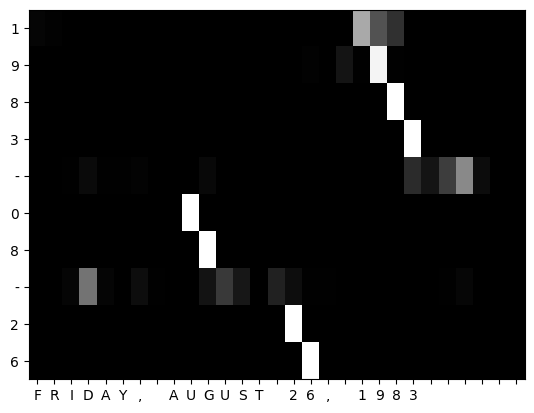

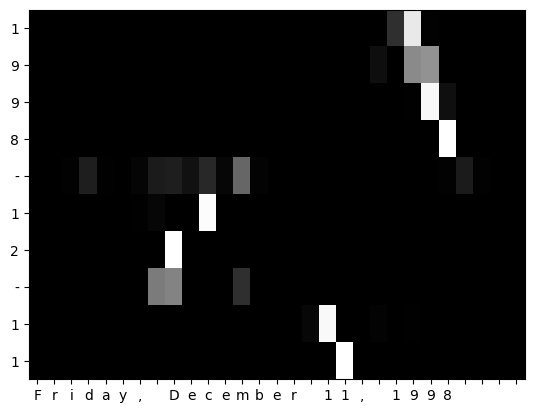

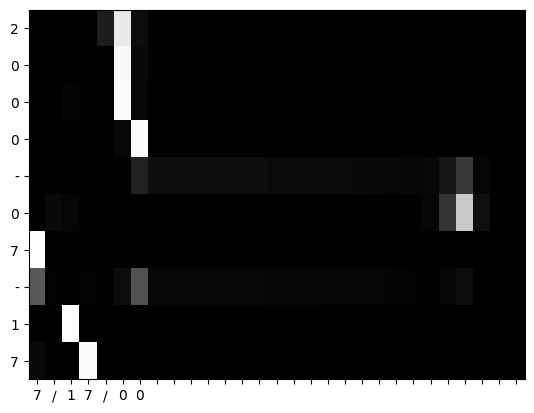

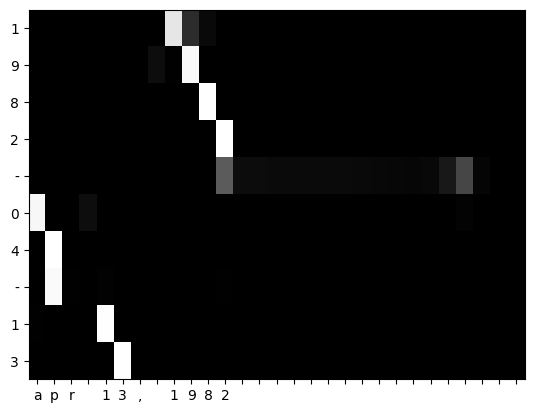

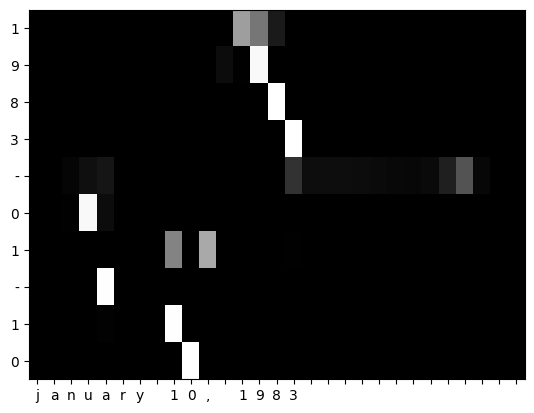

In [20]:
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)
